# Descriptiveness vs Performance (Thesis-Focused)

Minimal, high-signal analysis connecting descriptiveness to performance changes.

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuration
INPUT_DIR = "descriptiveness_out"
OUTPUT_DIR = "descriptiveness_out/figures"
SCORES_ORIG_DIR = "score_desc_original_name_original"
SCORES_AUG_DIR = "score_desc_augmented_name_augmented"
MIN_TOOLS_CATEGORY = 20
MIN_TOOLS_SUBCATEGORY = 10
MIN_TOOLS_SUBSUBCATEGORY = 10

SELECT_MODEL_FOR_SCATTER = None  # set to model name to filter
SELECT_MODEL = None
SELECT_CATEGORY = None
SELECT_SUBCATEGORY = None
SELECT_SUBSUBCATEGORY = None

os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.rcParams.update({"figure.autolayout": True})

def save_and_show(path):
    plt.savefig(path, dpi=300)
    plt.show()
    plt.close()

## Load data

In [2]:
def safe_read_csv(path):
    if not os.path.exists(path):
        print(f"Missing: {path}")
        return pd.DataFrame()
    return pd.read_csv(path)

tool_df = safe_read_csv(os.path.join(INPUT_DIR, "tool_level_metrics.csv"))
agg_overall = safe_read_csv(os.path.join(INPUT_DIR, "aggregate_overall.csv"))
agg_category = safe_read_csv(os.path.join(INPUT_DIR, "aggregate_by_category.csv"))
agg_subcategory = safe_read_csv(os.path.join(INPUT_DIR, "aggregate_by_subcategory.csv"))
agg_subsubcategory = safe_read_csv(os.path.join(INPUT_DIR, "aggregate_by_subsubcategory.csv"))

print(f"Tools: {len(tool_df)}")
print(f"Categories: {tool_df['category'].nunique() if 'category' in tool_df else 0}")
print(f"Subcategories: {tool_df['subcategory'].nunique() if 'subcategory' in tool_df else 0}")
print(f"Subsubcategories: {tool_df['subsubcategory'].nunique() if 'subsubcategory' in tool_df else 0}")
print("Columns:")
print(list(tool_df.columns))

Tools: 1931
Categories: 3
Subcategories: 5
Subsubcategories: 12
Columns:
['tool_id', 'category', 'subcategory', 'subsubcategory', 'aug_avg_sentence_len', 'aug_bullet_count', 'aug_char_count', 'aug_constraint_mention_count', 'aug_enum_field_coverage', 'aug_enum_value_mentions', 'aug_example_block_count', 'aug_flesch_kincaid_grade', 'aug_flesch_reading_ease', 'aug_has_edge_case_guidance', 'aug_has_example', 'aug_has_step_by_step', 'aug_line_count', 'aug_long_word_ratio', 'aug_nested_leaf_coverage', 'aug_param_name_coverage', 'aug_repetition_rate', 'aug_required_param_coverage', 'aug_sentence_count', 'aug_ttr', 'aug_type_coverage', 'aug_unique_word_count', 'aug_word_count', 'aug_word_entropy', 'delta_avg_sentence_len', 'delta_bullet_count', 'delta_char_count', 'delta_constraint_mention_count', 'delta_enum_field_coverage', 'delta_enum_value_mentions', 'delta_example_block_count', 'delta_flesch_kincaid_grade', 'delta_flesch_reading_ease', 'delta_has_edge_case_guidance', 'delta_has_example',

In [3]:
print(f"Unique subsubcategories: {tool_df['subsubcategory'].nunique()}")
print("\nSubsubcategory values:")
print(tool_df['subsubcategory'].unique())

Unique subsubcategories: 12

Subsubcategory values:
['simple_java' 'multiple' 'irrelevance' 'simple_javascript'
 'parallel_multiple' 'simple' 'base' 'memory' 'parallel' 'simple_python'
 'web_search' 'relevance']


## Data cleaning and core metrics

In [4]:
CORE_METRICS = [
    "word_count",
    "param_name_coverage",
    "required_param_coverage",
    "has_example",
    "example_block_count",
    "constraint_mention_count",
]
SCHEMA_METRICS = ["param_name_coverage", "required_param_coverage"]

def coerce_numeric(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

numeric_candidates = [
    col for col in tool_df.columns
    if col.startswith(("aug_", "orig_", "delta_")) or col in CORE_METRICS
]
coerce_numeric(tool_df, numeric_candidates)

for col in ["category", "subcategory", "subsubcategory"]:
    if col in tool_df.columns:
        tool_df[col] = tool_df[col].fillna("unknown").astype(str).str.strip()

if set(["category", "subcategory"]).issubset(tool_df.columns):
    tool_df["group"] = tool_df["category"] + "/" + tool_df["subcategory"]
if set(["category", "subcategory", "subsubcategory"]).issubset(tool_df.columns):
    tool_df["group3"] = tool_df["category"] + "/" + tool_df["subcategory"] + "/" + tool_df["subsubcategory"]


def metric_cols(metric):
    return f"orig_{metric}", f"aug_{metric}"


def describe_series(s):
    return {
        "median": s.median(),
        "p25": s.quantile(0.25),
        "p75": s.quantile(0.75),
    }


def has_data(series):
    return series is not None and series.dropna().shape[0] > 0

## Section 1: Overall descriptiveness summary

,metric,orig_median,orig_p25,orig_p75,aug_median,aug_p25,aug_p75,delta_median,delta_p25,delta_p75
0,word_count,13.0,10.0,18.0,132.0,125.0,138.0,119.0,115.0,120.0
1,param_name_coverage,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
2,required_param_coverage,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
3,has_example,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,example_block_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,constraint_mention_count,0.0,0.0,0.0,2.0,1.0,3.0,2.0,1.0,3.0


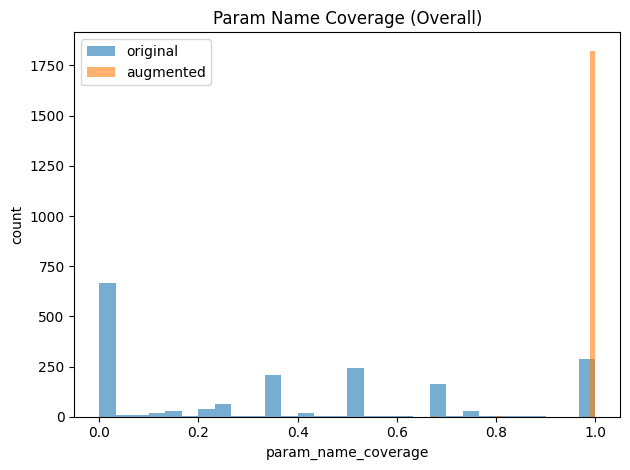

Saved: descriptiveness_out/figures\hist_param_name_coverage.png


In [5]:
rows = []
for metric in CORE_METRICS:
    orig_col, aug_col = metric_cols(metric)
    if orig_col in tool_df.columns or aug_col in tool_df.columns:
        row = {"metric": metric}
        if metric not in SCHEMA_METRICS and orig_col in tool_df.columns:
            s = tool_df[orig_col].dropna()
            if not s.empty:
                stats = describe_series(s)
                row.update({
                    "orig_median": stats["median"],
                    "orig_p25": stats["p25"],
                    "orig_p75": stats["p75"],
                })
        if aug_col in tool_df.columns:
            s = tool_df[aug_col].dropna()
            if not s.empty:
                stats = describe_series(s)
                row.update({
                    "aug_median": stats["median"],
                    "aug_p25": stats["p25"],
                    "aug_p75": stats["p75"],
                })
        if "orig_median" in row and "aug_median" in row:
            row["delta_median"] = row["aug_median"] - row["orig_median"]
        if "orig_p25" in row and "aug_p25" in row:
            row["delta_p25"] = row["aug_p25"] - row["orig_p25"]
        if "orig_p75" in row and "aug_p75" in row:
            row["delta_p75"] = row["aug_p75"] - row["orig_p75"]
        rows.append(row)

summary_df = pd.DataFrame(rows)
display(summary_df)

# Optional histogram: param_name_coverage (aug only if orig missing)
metric = "param_name_coverage"
orig_col, aug_col = metric_cols(metric)
if aug_col in tool_df.columns:
    aug_data = tool_df[aug_col].dropna()
    orig_data = tool_df[orig_col].dropna() if orig_col in tool_df.columns else pd.Series([], dtype=float)
    if has_data(aug_data):
        plt.figure()
        if has_data(orig_data):
            plt.hist(orig_data, bins=30, alpha=0.6, label="original")
        plt.hist(aug_data, bins=30, alpha=0.6, label="augmented")
        plt.title("Param Name Coverage (Overall)")
        plt.xlabel(metric)
        plt.ylabel("count")
        plt.legend()
        path = os.path.join(OUTPUT_DIR, "hist_param_name_coverage.png")
        save_and_show(path)
        print(f"Saved: {path}")

## Section 2: Category + subcategory comparison

In [ ]:
def grouped_stats(df, group_col, value_col, rate=False):
    stats = df.groupby(group_col)[value_col].agg(
        n_tools="count",
        median="median",
        p25=lambda x: x.quantile(0.25),
        p75=lambda x: x.quantile(0.75),
        mean="mean",
    ).reset_index()
    if rate:
        stats["median"] = stats["mean"]
    return stats

# Category plots with two series when available
metric = "param_name_coverage"
orig_col, aug_col = metric_cols(metric)
if "category" in tool_df.columns and aug_col in tool_df.columns:
    aug_stats = grouped_stats(tool_df[["category", aug_col]].dropna(), "category", aug_col)
    aug_stats = aug_stats[aug_stats["n_tools"] >= MIN_TOOLS_CATEGORY]
    if not aug_stats.empty:
        orig_stats = None
        if orig_col in tool_df.columns and metric not in SCHEMA_METRICS:
            orig_stats = grouped_stats(tool_df[["category", orig_col]].dropna(), "category", orig_col)
            orig_stats = orig_stats[orig_stats["n_tools"] >= MIN_TOOLS_CATEGORY]
        if orig_stats is not None and not orig_stats.empty:
            stats = orig_stats.merge(aug_stats, on="category", suffixes=("_orig", "_aug"))
            stats = stats.sort_values("median_aug", ascending=False)
            x = np.arange(len(stats))
            width = 0.4
            plt.figure()
            plt.bar(x - width / 2, stats["median_orig"], width, label="original")
            plt.bar(x + width / 2, stats["median_aug"], width, label="augmented")
            plt.title("Median Param Name Coverage by Category")
            plt.xlabel("category")
            plt.ylabel("median")
            plt.xticks(x, stats["category"], rotation=90)
            plt.legend()
            path = os.path.join(OUTPUT_DIR, "cat_param_name_coverage.png")
            save_and_show(path)
            print(f"Saved: {path}")

            table = stats[["category", "n_tools_orig", "median_orig", "p25_orig", "p75_orig", "median_aug", "p25_aug", "p75_aug"]].copy()
            table["delta_median"] = table["median_aug"] - table["median_orig"]
            display(table.head(10))
            display(table.tail(10))
        else:
            stats = aug_stats.sort_values("median", ascending=False)
            plt.figure()
            plt.bar(stats["category"], stats["median"], label="augmented")
            plt.title("Median Param Name Coverage by Category (Augmented)")
            plt.xlabel("category")
            plt.ylabel("median")
            plt.xticks(rotation=90)
            plt.legend()
            path = os.path.join(OUTPUT_DIR, "cat_param_name_coverage.png")
            save_and_show(path)
            print(f"Saved: {path}")

metric = "has_example"
orig_col, aug_col = metric_cols(metric)
if "category" in tool_df.columns and orig_col in tool_df.columns and aug_col in tool_df.columns:
    orig_stats = grouped_stats(tool_df[["category", orig_col]].dropna(), "category", orig_col, rate=True)
    aug_stats = grouped_stats(tool_df[["category", aug_col]].dropna(), "category", aug_col, rate=True)
    stats = orig_stats.merge(aug_stats, on="category", suffixes=("_orig", "_aug"))
    stats = stats[stats["n_tools_orig"] >= MIN_TOOLS_CATEGORY]
    if not stats.empty:
        stats = stats.sort_values("median_aug", ascending=False)
        x = np.arange(len(stats))
        width = 0.4
        plt.figure()
        plt.bar(x - width / 2, stats["median_orig"], width, label="original")
        plt.bar(x + width / 2, stats["median_aug"], width, label="augmented")
        plt.title("Has Example Rate by Category")
        plt.xlabel("category")
        plt.ylabel("rate")
        plt.xticks(x, stats["category"], rotation=90)
        plt.legend()
        path = os.path.join(OUTPUT_DIR, "cat_has_example_rate.png")
        save_and_show(path)
        print(f"Saved: {path}")

# Subcategory tables only (orig/aug/delta when available)
metric = "param_name_coverage"
orig_col, aug_col = metric_cols(metric)
if "group" in tool_df.columns and aug_col in tool_df.columns:
    aug_stats = grouped_stats(tool_df[["group", aug_col]].dropna(), "group", aug_col)
    aug_stats = aug_stats[aug_stats["n_tools"] >= MIN_TOOLS_SUBCATEGORY]
    orig_stats = None
    if orig_col in tool_df.columns and metric not in SCHEMA_METRICS:
        orig_stats = grouped_stats(tool_df[["group", orig_col]].dropna(), "group", orig_col)
        orig_stats = orig_stats[orig_stats["n_tools"] >= MIN_TOOLS_SUBCATEGORY]
    if orig_stats is not None and not orig_stats.empty:
        stats = orig_stats.merge(aug_stats, on="group", suffixes=("_orig", "_aug"))
        stats["delta_median"] = stats["median_aug"] - stats["median_orig"]
        stats_sorted = stats.sort_values("median_aug", ascending=False)
        display(stats_sorted.head(20))
        display(stats_sorted.tail(20))
    else:
        stats_sorted = aug_stats.sort_values("median", ascending=False)
        display(stats_sorted.head(20))
        display(stats_sorted.tail(20))

## Section 3: Subsubcategory spotlight linked to performance deltas

In [ ]:
def discover_score_csvs(base_dir):
    if not os.path.exists(base_dir):
        return []
    paths = []
    for root, _, files in os.walk(base_dir):
        for name in files:
            if name.endswith(".csv"):
                paths.append(os.path.join(root, name))
    return paths

def infer_model_from_path(base_dir, path):
    rel = os.path.relpath(path, base_dir)
    parts = rel.split(os.sep)
    return parts[0] if parts else "unknown"

def find_accuracy_column(df):
    for col in ["accuracy", "acc", "exact_match", "em"]:
        if col in df.columns:
            return col
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    return numeric_cols[0] if numeric_cols else None

def normalize_perf_df(df):
    if set(["category", "subcategory", "subsubcategory"]).issubset(df.columns):
        return df
    if set(["group_level", "group_name"]).issubset(df.columns):
        sub_df = df[df["group_level"] == "subsubcategory"].copy()
        if not sub_df.empty:
            parts = sub_df["group_name"].astype(str).str.split("/", expand=True)
            if parts.shape[1] >= 3:
                sub_df["category"] = parts[0]
                sub_df["subcategory"] = parts[1]
                sub_df["subsubcategory"] = parts[2]
                return sub_df
    return df

def load_scores(base_dir):
    rows = []
    for path in discover_score_csvs(base_dir):
        df = pd.read_csv(path)
        df = normalize_perf_df(df)
        acc_col = find_accuracy_column(df)
        if acc_col is None:
            continue
        model = df["model"].iloc[0] if "model" in df.columns else infer_model_from_path(base_dir, path)
        df = df.copy()
        df["model"] = model
        df["acc"] = pd.to_numeric(df[acc_col], errors="coerce")
        if set(["category", "subcategory", "subsubcategory"]).issubset(df.columns):
            rows.append(df[["model", "category", "subcategory", "subsubcategory", "acc"]])
    if not rows:
        return pd.DataFrame()
    return pd.concat(rows, ignore_index=True)

scores_orig = load_scores(SCORES_ORIG_DIR)
scores_aug = load_scores(SCORES_AUG_DIR)

if not scores_orig.empty and not scores_aug.empty:
    merged_perf = scores_orig.merge(
        scores_aug,
        on=["model", "category", "subcategory", "subsubcategory"],
        suffixes=("_orig", "_aug")
    )
    merged_perf["delta_acc"] = merged_perf["acc_aug"] - merged_perf["acc_orig"]
else:
    merged_perf = pd.DataFrame()

def safe_group_stat(df, col, agg="median"):
    if col not in df.columns:
        return None
    if agg == "mean":
        return df.groupby(["category", "subcategory", "subsubcategory"])[col].mean()
    return df.groupby(["category", "subcategory", "subsubcategory"])[col].median()

if set(["category", "subcategory", "subsubcategory"]).issubset(tool_df.columns):
    agg_orig_param = safe_group_stat(tool_df, "orig_param_name_coverage")
    agg_aug_param = safe_group_stat(tool_df, "aug_param_name_coverage")
    agg_orig_req = safe_group_stat(tool_df, "orig_required_param_coverage")
    agg_aug_req = safe_group_stat(tool_df, "aug_required_param_coverage")
    agg_orig_ex = safe_group_stat(tool_df, "orig_has_example", agg="mean")
    agg_aug_ex = safe_group_stat(tool_df, "aug_has_example", agg="mean")
    agg_orig_wc = safe_group_stat(tool_df, "orig_word_count")
    agg_aug_wc = safe_group_stat(tool_df, "aug_word_count")

    desc = pd.DataFrame(index=tool_df.groupby(["category", "subcategory", "subsubcategory"]).size().index)
    if agg_orig_param is not None:
        desc["desc_orig_median_param_coverage"] = agg_orig_param
    if agg_aug_param is not None:
        desc["desc_aug_median_param_coverage"] = agg_aug_param
    if agg_orig_req is not None:
        desc["desc_orig_median_required_param_coverage"] = agg_orig_req
    if agg_aug_req is not None:
        desc["desc_aug_median_required_param_coverage"] = agg_aug_req
    if agg_orig_ex is not None:
        desc["desc_orig_has_example_rate"] = agg_orig_ex
    if agg_aug_ex is not None:
        desc["desc_aug_has_example_rate"] = agg_aug_ex
    if agg_orig_wc is not None:
        desc["desc_orig_median_word_count"] = agg_orig_wc
    if agg_aug_wc is not None:
        desc["desc_aug_median_word_count"] = agg_aug_wc

    desc = desc.reset_index()
else:
    desc = pd.DataFrame()

if not merged_perf.empty and not desc.empty:
    perf_desc = merged_perf.merge(desc, on=["category", "subcategory", "subsubcategory"], how="left")
    if "desc_orig_median_param_coverage" in perf_desc.columns and "desc_aug_median_param_coverage" in perf_desc.columns:
        perf_desc["delta_param_coverage"] = perf_desc["desc_aug_median_param_coverage"] - perf_desc["desc_orig_median_param_coverage"]
    if "desc_orig_median_required_param_coverage" in perf_desc.columns and "desc_aug_median_required_param_coverage" in perf_desc.columns:
        perf_desc["delta_required_param_coverage"] = perf_desc["desc_aug_median_required_param_coverage"] - perf_desc["desc_orig_median_required_param_coverage"]
    if "desc_orig_has_example_rate" in perf_desc.columns and "desc_aug_has_example_rate" in perf_desc.columns:
        perf_desc["delta_has_example_rate"] = perf_desc["desc_aug_has_example_rate"] - perf_desc["desc_orig_has_example_rate"]
    if "desc_orig_median_word_count" in perf_desc.columns and "desc_aug_median_word_count" in perf_desc.columns:
        perf_desc["delta_word_count"] = perf_desc["desc_aug_median_word_count"] - perf_desc["desc_orig_median_word_count"]
else:
    perf_desc = pd.DataFrame()

if not perf_desc.empty:
    cols = [
        "model", "category", "subcategory", "subsubcategory",
        "acc_orig", "acc_aug", "delta_acc",
        "desc_orig_median_param_coverage", "desc_aug_median_param_coverage", "delta_param_coverage",
        "desc_orig_median_required_param_coverage", "desc_aug_median_required_param_coverage", "delta_required_param_coverage",
        "delta_has_example_rate", "delta_word_count",
    ]
    cols = [c for c in cols if c in perf_desc.columns]
    top_improvements = perf_desc.sort_values("delta_acc", ascending=False).head(10)[cols]
    top_regressions = perf_desc.sort_values("delta_acc", ascending=True).head(10)[cols]
    display(top_improvements)
    display(top_regressions)

    top_improvements.to_csv(os.path.join(OUTPUT_DIR, "top_improvements_subsubcategory.csv"), index=False)
    top_regressions.to_csv(os.path.join(OUTPUT_DIR, "top_regressions_subsubcategory.csv"), index=False)

    scatter_df = perf_desc.copy()
    if SELECT_MODEL_FOR_SCATTER:
        scatter_df = scatter_df[scatter_df["model"] == SELECT_MODEL_FOR_SCATTER]
    x_candidates = ["delta_param_coverage", "delta_required_param_coverage"]
    x_col = None
    for candidate in x_candidates:
        if candidate in scatter_df.columns and has_data(scatter_df[candidate]):
            x_col = candidate
            break
    if x_col and "delta_acc" in scatter_df.columns:
        df = scatter_df[[x_col, "delta_acc"]].dropna()
        if not df.empty:
            plt.figure()
            plt.scatter(df[x_col], df["delta_acc"], alpha=0.6)
            plt.title("Descriptiveness Delta vs Accuracy Delta (Subsubcategory)")
            plt.xlabel(x_col)
            plt.ylabel("delta_acc")
            path = os.path.join(OUTPUT_DIR, "scatter_delta_desc_vs_delta_acc.png")
            save_and_show(path)
            print(f"Saved: {path}")
    else:
        print("No valid delta descriptiveness column available for scatter plot.")

## Section 4: Drill-down helper

In [ ]:
def filter_slice(df):
    if df.empty:
        return df
    out = df.copy()
    if SELECT_CATEGORY:
        out = out[out["category"] == SELECT_CATEGORY]
    if SELECT_SUBCATEGORY:
        out = out[out["subcategory"] == SELECT_SUBCATEGORY]
    if SELECT_SUBSUBCATEGORY:
        out = out[out["subsubcategory"] == SELECT_SUBSUBCATEGORY]
    return out

# Descriptiveness stats (orig vs aug)
if set(["category", "subcategory", "subsubcategory"]).issubset(tool_df.columns):
    slice_df = filter_slice(tool_df)
    if not slice_df.empty:
        stats = {}
        for metric in ["param_name_coverage", "required_param_coverage", "has_example", "word_count"]:
            orig_col = f"orig_{metric}"
            aug_col = f"aug_{metric}"
            if metric not in SCHEMA_METRICS and orig_col in slice_df.columns:
                stats[f"orig_{metric}_median"] = slice_df[orig_col].median()
            if aug_col in slice_df.columns:
                stats[f"aug_{metric}_median"] = slice_df[aug_col].median()
            if metric not in SCHEMA_METRICS and orig_col in slice_df.columns and aug_col in slice_df.columns:
                stats[f"delta_{metric}_median"] = slice_df[aug_col].median() - slice_df[orig_col].median()
        display(pd.DataFrame([stats]))

# Performance metrics for slice
if "perf_desc" in locals() and not perf_desc.empty:
    perf_slice = filter_slice(perf_desc)
    if SELECT_MODEL:
        perf_slice = perf_slice[perf_slice["model"] == SELECT_MODEL]
    display(perf_slice)

# Tool examples (if descriptions are available)
desc_cols = [c for c in ["aug_description", "orig_description", "description"] if c in tool_df.columns]
if desc_cols:
    example_df = filter_slice(tool_df)
    example_df = example_df.head(3)
    for _, row in example_df.iterrows():
        name = row.get("tool_id", row.get("tool_name", ""))
        print(f"Tool: {name}")
        for c in desc_cols:
            text = str(row.get(c, ""))
            print(f"{c}: {text[:250]}")
        print("---")
else:
    print("No descriptions available in tool_level_metrics.csv for examples.")

## Saved outputs

In [ ]:
if os.path.exists(OUTPUT_DIR):
    files = sorted(f for f in os.listdir(OUTPUT_DIR) if f.endswith(".png") or f.endswith(".csv"))
    for f in files:
        print(f)
else:
    print("No output directory found.")